#Modelos Neuronales y secuenciales (Full Dataset)

##Carga de librerías y preparación de datos

Antes de preparar todo, elegimos el modelo a utilizar y alguna variable adicional:

In [0]:
skipDenseAct = True
skipLSTMAct = False
skipLSTM24Seg = False
skipLSTM24Agr = False

Para elegir qué celdas se ejecután y cuáles no:

Ahora pasamos a la carga de librerías y preparación de datos:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, LSTM, Dropout, BatchNormalization, GRU
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from importlib.machinery import SourceFileLoader
from keras.utils import plot_model

#LMG: Para Google la librería que controla qué ejecutar:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py'
  path_cell_controller = '/content/drive/My Drive/TFM/01.Utils/skip_kernel_extension.py'
  in_colab = True
except:
  path = '../utils/ESIOS_contoller.py'
  path_cell_controller = '../utils/skip_kernel_extension.py'
  in_colab = False
  
path_cell_controller = '/content/drive/My Drive/TFM/01.Utils/skip_kernel_extension.py'
cell_controller = SourceFileLoader('cell_controller', path_cell_controller).load_module()
%load_ext cell_controller

esios_assembler = SourceFileLoader('esios', path).load_module()

esios_controller = esios_assembler.ESIOS(in_colab)
data_consumo = esios_controller.get_data()

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Mostrando los datos de data_total.csv
(30555, 30)
________________________________________________________________________________


In [3]:
data_consumo.head()

,fecha,PVPC_DEF,PVPC_2_PED_NOC,PVPC_ELEC_NOC,date_timestamp,Demanda,Eolica,Nuclear,Solar,Solar_Fotovoltaica,Solar_Termica,Termica_Renovable,Prevista,Programada,date_day,Brent_price,Holiday,Precio de Regulación Secundaria subir,Precio de Regulación Secundaria bajar,Precio mercado SPOT Diario_x,Demanda real,Generación prevista Solar,Saldo total interconexiones programa p48,Generación programada P48 Exportación Portugal,Generación programada P48 Exportación Francia,Generación programada P48 Importación Portugal,Generación programada P48 Importación Francia,Precio SPOT PT,Precio SPOT FR,PVPC-target
0,2015-10-01 00:00:00+02:00,117.77,69.49,71.88,1.443650e+09,24984.666667,1003.666667,6012.833333,402.166667,33.0,368.500000,580.166667,24691.833333,24517.0,2015-10-01,47.48,0.0,61.18,49.13,56.65,25305.0,267.6,182.4,-606.6,-351.4,1232.1,1200.0,56.65,38.56,123.30
1,2015-10-01 01:00:00+02:00,117.09,68.21,65.57,1.443654e+09,23550.833333,899.000000,6013.166667,174.833333,33.0,141.333333,584.166667,23440.000000,23169.0,2015-10-01,47.48,0.0,59.59,49.13,53.50,23959.0,195.7,-269.5,-1112.5,-351.4,1232.1,1200.0,53.50,31.27,121.98
2,2015-10-01 02:00:00+02:00,114.59,65.34,62.53,1.443658e+09,22648.166667,927.500000,6013.500000,103.833333,33.0,70.666667,585.833333,22521.166667,22437.0,2015-10-01,47.48,0.0,56.27,49.13,49.69,22873.0,202.1,94.0,-951.0,-351.4,1232.1,1200.0,49.69,30.66,126.70
3,2015-10-01 03:00:00+02:00,116.60,66.53,63.40,1.443661e+09,22203.833333,935.666667,6013.000000,102.000000,33.0,69.000000,588.500000,22335.333333,22281.0,2015-10-01,47.48,0.0,45.99,45.50,49.10,22550.0,61.3,319.7,-846.3,-351.4,1232.1,1200.0,49.10,29.14,131.63
4,2015-10-01 04:00:00+02:00,122.07,71.03,67.37,1.443665e+09,21987.833333,900.833333,6014.166667,101.666667,33.0,68.166667,589.000000,22177.833333,21910.0,2015-10-01,47.48,0.0,52.28,49.13,51.25,22017.0,45.1,405.5,-760.5,-351.4,1232.1,1200.0,51.25,29.40,134.73


##Predicción hora actual con los datos actuales

Tomamos como variables el precio y el diferenciado. 

El valor diferencial ha de ser entre el día de ayer y el de antes de ayer, ya que el valor de hoy no lo tenemos a priori (sería el objetivo a calcular). Por ello, el cálculo de ésta empezará el día 3. De manera similar, el precio de ayer lo tendremos un día depués:

In [0]:
#------
#X_data
#------
x_data = data_consumo[['PVPC_DEF']].copy()

data_1 = data_consumo['PVPC_DEF']
data_2 = data_consumo['PVPC_DEF'].shift(periods=24, axis = 0)
x_data['PVPC_stationary_yesterday'] = (data_1 - data_2)
x_data = x_data.bfill()


x_data_columns = x_data.columns

#------
#Y_data
#------
y_data = data_consumo[['PVPC-target']].copy()
y_data_columns = y_data.columns

In [5]:
x_data.head()

,PVPC_DEF,PVPC_stationary_yesterday
0,117.77,5.53
1,117.09,5.53
2,114.59,5.53
3,116.60,5.53
4,122.07,5.53


In [6]:
y_data.head()

,PVPC-target
0,123.30
1,121.98
2,126.70
3,131.63
4,134.73


Separamos los datos en train y test, y los normalizamos:

In [7]:
#Min-max scaler
scaler = MinMaxScaler()
x_data_norm = scaler.fit_transform(x_data)
y_data_norm = scaler.fit_transform(y_data)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_data_norm, y_data_norm, test_size=0.33, shuffle=False)

#Convert NaN values to 0:
x_train = np.nan_to_num(x_train)
x_valid = np.nan_to_num(x_valid)
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)

print('Xtrain_dim:', x_train.shape)
print('Ytrain_dim:', y_train.shape)

Xtrain_dim: (20471, 2)
Ytrain_dim: (20471, 1)


Veamos cómo queda:

In [8]:
x_train_DF = pd.DataFrame(x_train, columns = x_data_columns)
x_train_DF.head()

,PVPC_DEF,PVPC_stationary_yesterday
0,0.468270,0.525143
1,0.462688,0.525143
2,0.442164,0.525143
3,0.458665,0.525143
4,0.503571,0.525143


Por último, generamos funciones y variables de utilidad a lo largo de todos los modelos:

In [0]:
def rmse (y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

###NN

Red neuronal densa como punto de partida.

####Preparación de datos

Primero, estandarizamos los **datos de entrenamiento**:

In [0]:
%%skip $skipDenseAct

scaler = MinMaxScaler()
x_train_data = scaler.fit_transform(x_train)
y_train_data = scaler.fit_transform(y_train)
x_valid_data = x_valid
y_valid_data = y_valid

print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
print('Test:',x_valid_data.shape, y_valid_data.shape)

Para visualizar (ver apartado Visualización de dataframes al final):

In [0]:
%%skip $skipDenseAct
 
x_train_data_DF = pd.DataFrame(x_train_data, columns = x_data_columns)
display(x_train_data_DF[0:5])

In [0]:
%%skip $skipDenseAct

y_train_data_DF = pd.DataFrame(y_train_data, columns = y_data_columns)
display(y_train_data_DF[0:5])

Por último, definimos los tamaños de nuestra red y algunas variables adicionales

####Modelo

In [0]:
%%skip $skipDenseAct

#Carga variables:
split_steps = 5
num_steps = split_steps
output_size = y_train_data.shape[1]
batch_size = 30

In [0]:
%%skip $skipDenseAct

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(num_var,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(output_size, activation='linear'))

# compile mode
model.compile(optimizer='adam', loss='mse', metrics=['mse',rmse,'mae','mape'])
print(model.summary())

####Entrenamiento

In [0]:
%%skip $skipDenseAct

history_train = model.fit(x_train_data, y_train_data, 
                          epochs=100, 
                          batch_size=batch_size, 
                          shuffle=False,
                          verbose=1)

# summarize history for loss, MAPE in a different scale than the others
plt.plot(history_train.history['mean_squared_error'])
plt.plot(history_train.history['mean_absolute_error'])
plt.plot(history_train.history['rmse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE','MAE','RMSE'], loc='upper left')
plt.show()

plt.plot(history_train.history['mean_absolute_percentage_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MAPE'], loc='upper left')
plt.show()

####Test

Para el test:

In [0]:
%%skip $skipDenseAct

scores_test = model.evaluate(x_valid_data, y_valid_data, batch_size=batch_size, verbose=1)

# summarize loss
for element in range(len(scores_test)):
  print("%s: %.2f" % (model.metrics_names[element], scores_test[element]))

In [0]:
%%skip $skipDenseAct

x_valid_data_DF = pd.DataFrame(x_valid_data, columns = x_data_columns)
display(x_valid_data_DF[0:5])

In [0]:
%%skip $skipDenseAct

y_valid_data_DF = pd.DataFrame(y_valid_data, columns = y_data_columns)
display(y_valid_data_DF[0:5])

In [0]:
%%skip $skipDenseAct

y_predict = model.predict(x_valid_data, batch_size=batch_size, verbose=1)

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.title('Real')
plt.subplot(313)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

###LSTM

Basado en el ejemplo completo que está explicado en https://adventuresinmachinelearning.com/keras-lstm-tutorial/

####Preparación de datos

In [0]:
%%skip $skipLSTMAct

#Carga variables:
split_steps = 5
num_steps = split_steps
batch_size = 30

Para que se ejecute en paquetes, replicamos el dataset de n en n lotes:

In [0]:
%%skip $skipLSTMAct

# split a sequence into samples
def split_sequence(sequence, n_steps):
  X = list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x = sequence[i:end_ix,:]
    X.append(seq_x)

  return np.array(X)

Después, estandarizamos los **datos de entrenamiento** y aplicamos la función a la x e y, agrupando las salidas por paquetes de num_steps:

In [11]:
%%skip $skipLSTMAct

x_train_est = x_train
y_train_est = y_train

x_train_data = split_sequence(x_train_est, split_steps)
y_train_data = y_train_est[split_steps:,:]
x_valid_data = split_sequence(x_valid, split_steps)
y_valid_data = y_valid[split_steps:,:]

print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
print('Test:',x_valid_data.shape, y_valid_data.shape)

Entrenamiento: (20466, 5, 2) (20466, 1)
Test: (10079, 5, 2) (10079, 1)


Para visualizar uno de los datos que van a entrar (ver apartado Visualización de dataframes al final):

In [12]:
%%skip $skipLSTMAct

x_train_data_DF = pd.DataFrame(x_train_data[0,:,:], columns = x_data_columns)
display(x_train_data_DF[0:5])

,PVPC_DEF,PVPC_stationary_yesterday
0,0.468270,0.525143
1,0.462688,0.525143
2,0.442164,0.525143
3,0.458665,0.525143
4,0.503571,0.525143


In [13]:
%%skip $skipLSTMAct

y_train_data_DF = pd.DataFrame(y_train_data[0:split_steps], columns = y_data_columns)
display(y_train_data_DF[0:5])

,PVPC-target
0,0.724170
1,0.724280
2,0.715131
3,0.701874
4,0.698641


Por último, definimos los tamaños de nuestra red y algunas variables adicionales:

En nuestro caso, la entrada va a ser de *1* **x** *nº de datos tomados* **x** *nº de variables independientes*, siendo:

- batch_size, para cada instante tomamos los datos en paquetes.
- nº de datos tomados o num_steps, esto es, en el análisis secuencial cada registro energético completo con el que contamos, o en términos más coloquiales, cuántas filas del dataset se tienen en cuenta .
- nº de variables independientes o num_var, cada registro en los datos de entrada, o en términos más coloquiales, cada columna del dataset.

Además:

- hidden_size, número de unidades en cada célula del LSTM.

- A la salida, tenemos los tres valores a estimar.

In [0]:
%%skip $skipLSTMAct

#Carga variables:
num_var = x_train_data.shape[2]
output_size = y_train_data.shape[1]

####Modelo

A la capa LSTM se le pasa cada vez un instante, siendo el primero el t1, el segundo el t2, etc.

Respecto al ejemplo en la página, hemos:
- Quitado el embedding inicial, ya que no necesitamos codificar la entrada (ya son valores en sí mismos).
- Cambiado el hidden-layer-size. En la página dicen que se suele poner al tamaño de entrada de cada registro. Viene a ser el símil de unidades en una capa densa.
- Dejado una única capa LSTM.
- Eliminado el dropout.
- TimeDistributed usa una capa densa para cada step del entrenamiento. La quitamos también y dejamos la densa exclusivamente, ya que hace la salida muy grande.

Además:

- No usamos regularización ni Dropout, ya que no hay problemas de overfitting.
- Usamos normalización entre capas y a la entrada (BatchNormalization). Por ello, nos ahorramos calcular los biases, ya que no tiene sentido.

Así:


In [0]:
%%skip $skipLSTMAct

# define model
model = Sequential()

#LSTM tiene por defecto inicialización Xavier, que para problemas lineales es la recomendada
model.add(LSTM(100, input_shape=(num_steps,num_var)))
model.add(Activation("relu"))
#model.add(Dropout(0.2))

model.add(Dense(output_size))
model.add(Activation("linear"))

# compile mode
model.compile(optimizer='adam', loss='mse', metrics=['mse',rmse,'mae','mape'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41200     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%skip $skipLSTMAct

plot_model(model,show_shapes=True)

####Entrenamiento

LSTM
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





20466/20466 [==============================] - 6s 306us/step - loss: 0.0121 - mean_squared_error: 0.0121 - rmse: 0.0652 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 10.9210
Epoch 2/100
20466/20466 [==============================] - 5s 243us/step - loss: 0.0042 - mean_squared_error: 0.0042 - rmse: 0.0486 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 8.3292
Epoch 3/100
20466/20466 [==============================] - 5s 240us/step - loss: 0.0041 - mean_squared_error: 0.0041 - rmse: 0.0478 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 8.2342
Epoch 4/100
20466/20466 [==============================] - 5s 242us/step - loss: 0.0041 - mean_squared_error: 0.0041 - rmse: 0.0473 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 8.1625
Epoch 5/100
20466/20466 [==============================] - 5s 243us/step - loss:

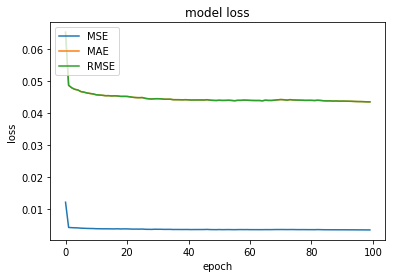

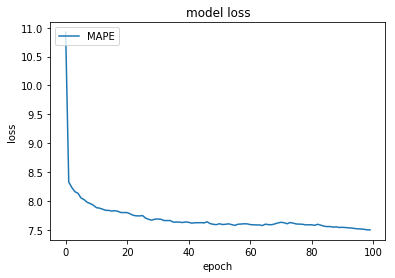

In [0]:
%%skip $skipLSTMAct

print('LSTM')
history_train = model.fit(x_train_data, y_train_data, 
                          epochs=100, 
                          batch_size=batch_size, 
                          shuffle=False,
                          verbose=1)

# summarize history for loss, MAPE in a different scale than the others
plt.plot(history_train.history['mean_squared_error'])
plt.plot(history_train.history['mean_absolute_error'])
plt.plot(history_train.history['rmse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE','MAE','RMSE'], loc='upper left')
plt.show()

plt.plot(history_train.history['mean_absolute_percentage_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MAPE'], loc='upper left')
plt.show()

####Test

Para el test:

In [0]:
%%skip $skipLSTMAct

scores_test = model.evaluate(x_valid_data, y_valid_data, batch_size=batch_size, verbose=1)

# summarize loss
for element in range(len(scores_test)):
  print("%s: %.2f" % (model.metrics_names[element], scores_test[element]))

10079/10079 [==============================] - 1s 54us/step
loss: 0.01
mean_squared_error: 0.01
rmse: 0.06
mean_absolute_error: 0.06
mean_absolute_percentage_error: 1407730.39


In [0]:
%%skip $skipLSTMAct

x_valid_data_DF = pd.DataFrame(x_valid_data[0,:,:], columns = x_data_columns)
display(x_valid_data_DF)

,PVPC_DEF,PVPC_stationary_yesterday
0,0.482637,0.548007
1,0.483129,0.551769
2,0.482883,0.545330
3,0.502996,0.563997
4,0.522946,0.551769


In [0]:
%%skip $skipLSTMAct

y_valid_data_DF = pd.DataFrame(y_valid_data[0:5,:], columns = y_data_columns)
display(y_valid_data_DF)

,PVPC-target
0,0.680673
1,0.678974
2,0.662540
3,0.679194
4,0.679194


10079/10079 [==============================] - 1s 51us/step


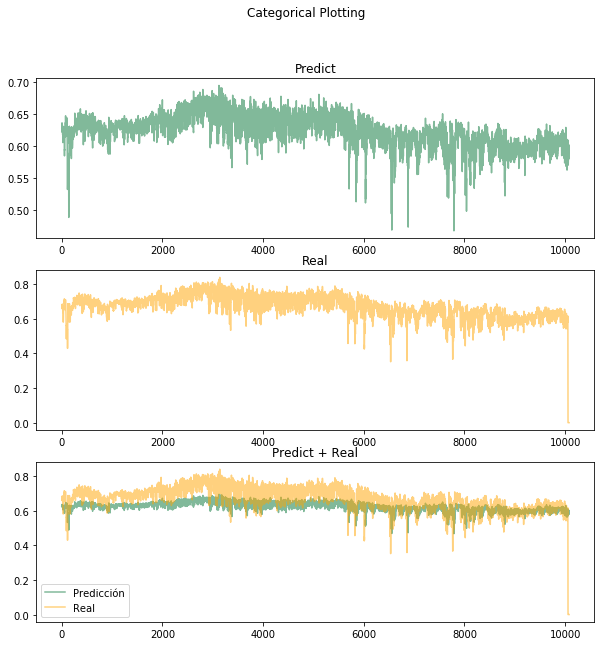

In [0]:
%%skip $skipLSTMAct

y_predict = model.predict(x_valid_data, batch_size=batch_size, verbose=1)

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.title('Real')
plt.subplot(313)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

##Predicción a 24 h con los datos actuales (segregado por horas)

Sería la predicción de mañana una vez tenemos los datos de la hora actual, incluido el precio.

En los ejercicios anteriores hemos calculado la predicción a la hora siguiente. En este ejercicio vamos a intentar calcular la predicción con la hora del día siguiente, para ello utilizaremos el PVPC_DEF como precio de la hora actual, el PVCP-target como el precio de la hora del día siguiente, y calcularemos la diferencia moviendose una ventana de 24 horas. 


###LSTM

####Preparación de datos

In [0]:
%%skip $skipLSTM24Seg

#Carga variables:
split_steps = 5
num_steps = split_steps
batch_size = 30

In [0]:
%%skip $skipLSTM24Seg

#------
#X_data
#------
x_data = data_consumo[['PVPC_DEF']].copy()

data_1 = data_consumo['PVPC_DEF']
data_2 = data_consumo['PVPC_DEF'].shift(periods=24, axis = 0)
x_data['PVPC_stationary_yesterday'] = (data_1 - data_2)
x_data = x_data.bfill()


x_data_columns = x_data.columns

#------
#Y_data
#------
y_data = data_consumo[['PVPC-target']].copy()
y_data_columns = y_data.columns

In [0]:
%%skip $skipLSTM24Seg

x_data[0:2]

In [0]:
%%skip $skipLSTM24Seg

x_data[24:26]

In [0]:
%%skip $skipLSTM24Seg

y_data.head()

In [0]:
%%skip $skipLSTM24Seg

#Min-max scaler
scaler = MinMaxScaler()
x_data_norm = scaler.fit_transform(x_data)
y_data_norm = scaler.fit_transform(y_data)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_data_norm, y_data_norm, test_size=0.33, shuffle=False)

#Convert NaN values to 0:
x_train = np.nan_to_num(x_train)
x_valid = np.nan_to_num(x_valid)
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)

print('Xtrain_dim:', x_train.shape)
print('Ytrain_dim:', y_train.shape)

Xtrain_dim: (20471, 2)
Ytrain_dim: (20471, 1)


In [0]:
%%skip $skipLSTM24Seg

x_train_est = x_train
y_train_est = y_train

x_train_data = split_sequence(x_train_est, split_steps)
y_train_data = y_train_est[split_steps:,:]
x_valid_data = split_sequence(x_valid, split_steps)
y_valid_data = y_valid[split_steps:,:]

print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
print('Test:',x_valid_data.shape, y_valid_data.shape)

Entrenamiento: (20466, 5, 2) (20466, 1)
Test: (10079, 5, 2) (10079, 1)


In [0]:
%%skip $skipLSTM24Seg

#Carga variables:
num_var = x_train_data.shape[2]
output_size = y_train_data.shape[1]

#### Modelo
Mismo modelo que los entrenados anteriormente

In [0]:
%%skip $skipLSTM24Seg

# define model
model = Sequential()

#LSTM tiene por defecto inicialización Xavier, que para problemas lineales es la recomendada
model.add(LSTM(100, input_shape=(num_steps,num_var)))
model.add(Activation("relu"))

model.add(Dense(output_size))
model.add(Activation("linear"))

# compile mode
model.compile(optimizer='adam', loss='mse', metrics=['mse',rmse,'mae','mape'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


LSTM
Epoch 1/100
20466/20466 [==============================] - 6s 276us/step - loss: 0.0111 - mean_squared_error: 0.0111 - rmse: 0.0641 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 10.7485
Epoch 2/100
20466/20466 [==============================] - 5s 238us/step - loss: 0.0042 - mean_squared_error: 0.0042 - rmse: 0.0485 - mean_absolute_error: 0.0485 - mean_absolute_percentage_error: 8.3201
Epoch 3/100
20466/20466 [==============================] - 5s 236us/step - loss: 0.0041 - mean_squared_error: 0.0041 - rmse: 0.0479 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 8.2452
Epoch 4/100
20466/20466 [==============================] - 5s 241us/step - loss: 0.0041 - mean_squared_error: 0.0041 - rmse: 0.0476 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 8.2047
Epoch 5/100
20466/20466 [==============================] - 5s 235us/step - loss: 0.0041 - mean_squared_error: 0.0041 - rmse: 0.0472 - mean_absolute_error: 0.0472 - mean_absolute_perc

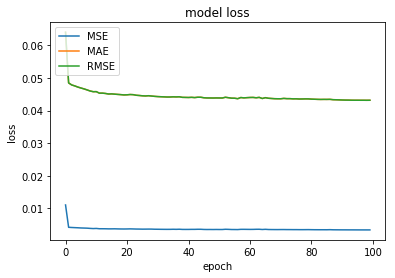

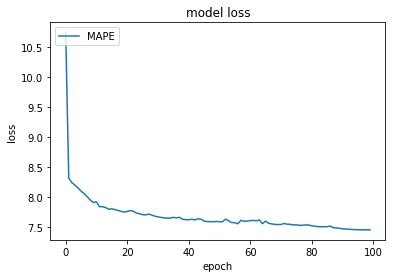

In [0]:
%%skip $skipLSTM24Seg

print('LSTM')
history_train = model.fit(x_train_data, y_train_data, 
                          epochs=100, 
                          batch_size=batch_size, 
                          shuffle=False,
                          verbose=1)

# summarize history for loss, MAPE in a different scale than the others
plt.plot(history_train.history['mean_squared_error'])
plt.plot(history_train.history['mean_absolute_error'])
plt.plot(history_train.history['rmse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE','MAE','RMSE'], loc='upper left')
plt.show()

plt.plot(history_train.history['mean_absolute_percentage_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MAPE'], loc='upper left')
plt.show()

#### Plot

10079/10079 [==============================] - 1s 59us/step


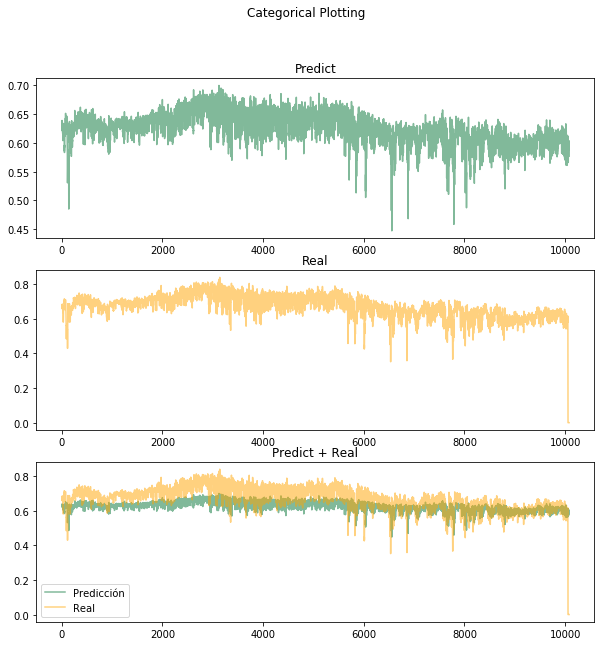

In [0]:
%%skip $skipLSTM24Seg

y_predict = model.predict(x_valid_data, batch_size=batch_size, verbose=1)

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.title('Real')
plt.subplot(313)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

#### Metrics

In [0]:
%%skip $skipLSTM24Seg

esios_controller.get_metrics(y_valid_data, y_predict)

** --------------- Metrics: --------------- **
MSE:  0.005397443823516547
RMSE:  0.07346729764675264
MAE:  0.05827285406503227
Log_MSE:  0.0021590513600753315
MedianAE:  0.05390472364174892
MAPE:  inf %
SMAPE:  9.119202853206113 %
Variance:  0.32209286441376495
Max Error:  0.6098700761795044
** ---------------------------------------- **


/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py:125: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(abs((y_real-y_pred)/y_real))*100


#### Plot real

Vamos a aplicarle el scaler inverse para ver las predicciones reales

In [0]:
%%skip $skipLSTM24Seg

y_predict_trans = scaler.inverse_transform(y_predict)
y_valid_trans = scaler.inverse_transform(y_valid_data)

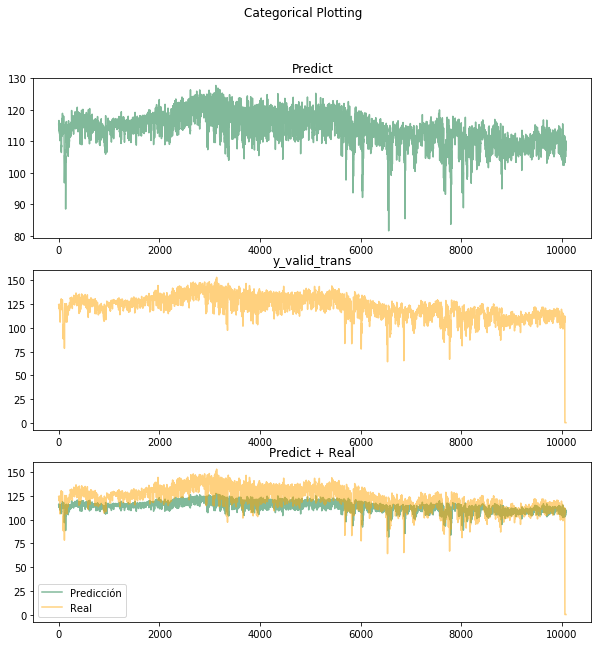

In [0]:
%%skip $skipLSTM24Seg

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(y_predict_trans, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(y_valid_trans, c='orange', alpha=0.5)
plt.title('y_valid_trans')
plt.subplot(313)
plt.plot(y_predict_trans, c='seagreen', alpha=0.6)
plt.plot(y_valid_trans, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

#### Metrics real

In [0]:
%%skip $skipLSTM24Seg

esios_controller.get_metrics(y_valid_trans, y_predict_trans)

** --------------- Metrics: --------------- **
MSE:  179.84742499035247
RMSE:  13.41072052465312
MAE:  10.637126783765913
Log_MSE:  0.06266044670560658
MedianAE:  9.839766845703124
MAPE:  inf %
SMAPE:  9.119202854542545 %
Variance:  0.32209286078408117
Max Error:  111.32568359375
** ---------------------------------------- **


/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py:125: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(abs((y_real-y_pred)/y_real))*100


## Predicción a 24 h con los datos actuales (agrupado por día)

###LSTM

#### Preparación de datos
En este caso nos vamos a traer los datos agrupados diariamente, aplicaremos el mismo proceso que hemos aplicado antes, y esta vez la diferencia entre el día de hoy y el anterior será de 1 período.

In [0]:
%%skip $skipLSTM24Agr

#Carga variables:
split_steps = 5
num_steps = split_steps
batch_size = 30

In [0]:
%%skip $skipLSTM24Agr

x_data_grouped = esios_controller.get_df_daily()
x_data = list()
y_data = list()

x_data = x_data_grouped[['PVPC_DEF']].copy()

data_1 = x_data_grouped['PVPC_DEF']
data_2 = x_data_grouped['PVPC_DEF'].shift(periods=1, axis = 0)
x_data['PVPC_stationary_yesterday'] = (data_1 - data_2)
x_data = x_data.bfill()


x_data_columns = x_data.columns


#------
#Y_data
#------
y_data = pd.DataFrame(x_data_grouped['PVPC_DEF'].shift(periods=-1, axis = 0).copy())

In [16]:
%%skip $skipLSTM24Agr

display(x_data[0:5])

,PVPC_DEF,PVPC_stationary_yesterday
fecha,,
2015-09-30 00:00:00+00:00,117.430000,7.168571
2015-10-01 00:00:00+00:00,124.598571,7.168571
2015-10-02 00:00:00+00:00,122.746957,-1.851615
2015-10-03 00:00:00+00:00,114.161667,-8.585290
2015-10-04 00:00:00+00:00,101.120833,-13.040833


In [17]:
%%skip $skipLSTM24Agr

display(y_data[0:5])

,PVPC_DEF
fecha,
2015-09-30 00:00:00+00:00,124.598571
2015-10-01 00:00:00+00:00,122.746957
2015-10-02 00:00:00+00:00,114.161667
2015-10-03 00:00:00+00:00,101.120833
2015-10-04 00:00:00+00:00,106.640000


In [18]:
%%skip $skipLSTM24Agr

#Min-max scaler
scaler = MinMaxScaler()
x_data_norm = scaler.fit_transform(x_data)
y_data_norm = scaler.fit_transform(y_data)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_data_norm, y_data_norm, test_size=0.33, shuffle=False)

#Convert NaN values to 0:
x_train = np.nan_to_num(x_train)
x_valid = np.nan_to_num(x_valid)
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)

print('Xtrain_dim:', x_train.shape)
print('Ytrain_dim:', y_train.shape)

Xtrain_dim: (938, 2)
Ytrain_dim: (938, 1)


In [19]:
%%skip $skipLSTM24Agr

x_train_est = x_train
y_train_est = y_train

x_train_data = split_sequence(x_train_est, split_steps)
y_train_data = y_train_est[split_steps:,:]
x_valid_data = split_sequence(x_valid, split_steps)
y_valid_data = y_valid[split_steps:,:]

print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
print('Test:',x_valid_data.shape, y_valid_data.shape)

Entrenamiento: (933, 5, 2) (933, 1)
Test: (458, 5, 2) (458, 1)


In [0]:
%%skip $skipLSTM24Agr

#Carga variables:
num_var = x_train_data.shape[2]
output_size = y_train_data.shape[1]

#### Modelo
Mismo modelo que los entrenados anteriormente

In [30]:
%%skip $skipLSTM24Agr

# define model
model = Sequential()

#LSTM tiene por defecto inicialización Xavier, que para problemas lineales es la recomendada
model.add(LSTM(100, input_shape=(num_steps,num_var)))
model.add(Activation("relu"))

model.add(Dense(output_size))
model.add(Activation("linear"))

# compile mode
model.compile(optimizer='adam', loss='mse', metrics=['mse',rmse,'mae','mape'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


LSTM
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
933/933 [==============================] - 1s 2ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - rmse: 0.1535 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 99858.3213
Epoch 2/300
933/933 [==============================] - 0s 344us/step - loss: 0.0141 - mean_squared_error: 0.0141 - rmse: 0.0851 - mean_absolute_error: 0.0851 - mean_absolute_percentage_error: 382920.5621
Epoch 3/300
933/933 [==============================] - 0s 277us/step - loss: 0.0138 - mean_squared_error: 0.0138 - rmse: 0.0843 - mean_absolute_error: 0.0843 - mean_absolute_percentage_error: 410951.9217
Epoch 4/300
933/933 [==============================] - 0s 284us/step - loss: 0.0122 - mean_squared_error: 0.0122 - rmse: 0.0786 - mean_absolute_error: 0.0786 - mean_absolute_percentage_error: 404783.3521
Epoch 5/300
933/933 [==============================] - 0s 277us/step - loss: 0.0109 - 

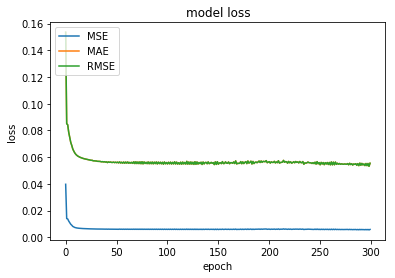

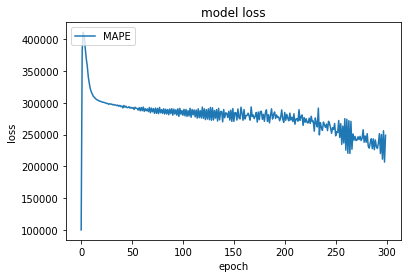

In [31]:
%%skip $skipLSTM24Agr

print('LSTM')
history_train = model.fit(x_train_data, y_train_data, 
                          epochs=300, 
                          batch_size=batch_size, 
                          shuffle=False,
                          verbose=1)

# summarize history for loss, MAPE in a different scale than the others
plt.plot(history_train.history['mean_squared_error'])
plt.plot(history_train.history['mean_absolute_error'])
plt.plot(history_train.history['rmse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE','MAE','RMSE'], loc='upper left')
plt.show()

plt.plot(history_train.history['mean_absolute_percentage_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MAPE'], loc='upper left')
plt.show()

458/458 [==============================] - 0s 342us/step


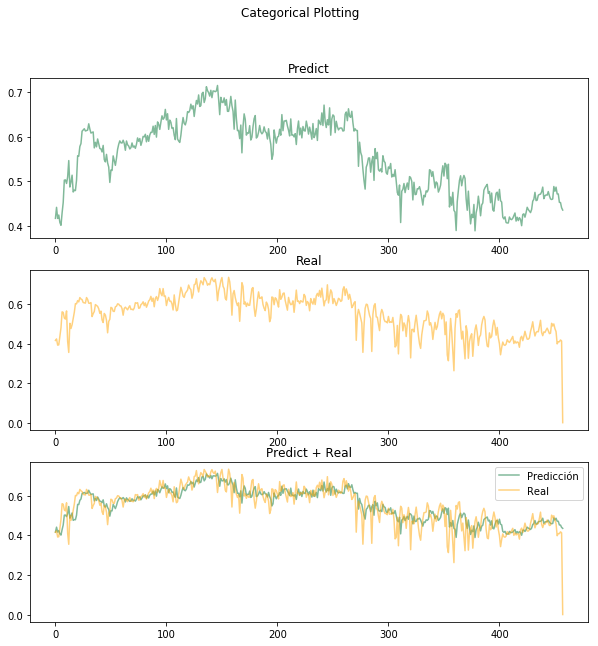

In [32]:
%%skip $skipLSTM24Agr

y_predict = model.predict(x_valid_data, batch_size=batch_size, verbose=1)

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.title('Real')
plt.subplot(313)
plt.plot(y_predict, c='seagreen', alpha=0.6)
plt.plot(y_valid_data, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

#### Encoder

Nos traemos el encoder y hacemos la predicción

In [33]:
%%skip $skipLSTM24Agr

y_predict_trans = scaler.inverse_transform(y_predict)
y_valid_trans = scaler.inverse_transform(y_valid_data)

predictions = pd.DataFrame(y_predict_trans)
print(np.shape(predictions))
print(np.shape(y_valid_trans))

(458, 1)
(458, 1)


In [0]:
%%skip $skipLSTM24Agr

predictions['Holiday'] = x_data_grouped[-458:]['Holiday'].values
np.shape(predictions)

importar el encoder

In [35]:
%%skip $skipLSTM24Agr

encoder = esios_controller.load_keras_model('/content/drive/My Drive/TFM/01.Utils/data/Encoder.json')

/content/drive/My Drive/TFM/01.Utils/data/Encoder.json
Loaded model from disk


In [36]:
%%skip $skipLSTM24Agr

all_day_real_preds = encoder.predict(predictions);
print(np.shape(all_day_real_preds))

(458, 24)


#### Predic data parse

Como en todos los días no tenemos el total de las 24 horas debemos eliminar algunas de estas en el predict, que este sí que genera las 24. 

In [0]:
%%skip $skipLSTM24Agr

y_data_target = esios_controller.get_df_daily_target_day_prics()
y_data_target = pd.DataFrame(y_data_target.values.tolist(), columns=['h'+str(i) for i in range(24)])

y_data_target_for_test = y_data_target[-458:]
np.shape(y_data_target_for_test)

In [38]:
%%skip $skipLSTM24Agr

import math
pred = list()
real = list()

day_key = 0
for day in y_data_target_for_test.values:
  hour_key = 0
  for hour in day:
    if not math.isnan(hour) and hour != 0:
      real.append(hour)
      pred.append(all_day_real_preds[day_key][hour_key])
    hour_key += 1 
  day_key += 1  
  
  
print(np.shape(pred))
print(np.shape(real))  

(10237,)
(10237,)


#### Plot

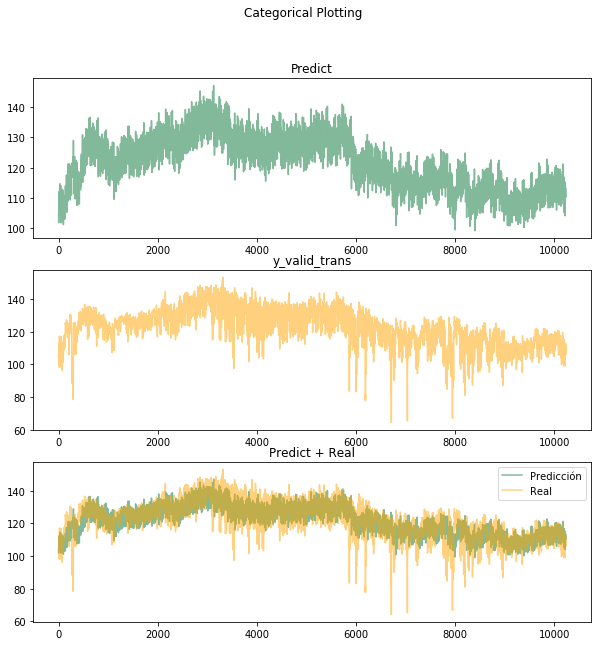

In [40]:
%%skip $skipLSTM24Agr

plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.plot(pred, c='seagreen', alpha=0.6)
plt.title('Predict')
plt.subplot(312)
plt.plot(real, c='orange', alpha=0.5)
plt.title('y_valid_trans')
plt.subplot(313)
plt.plot(pred, c='seagreen', alpha=0.6)
plt.plot(real, c='orange', alpha=0.5)
plt.legend(['Predicción','Real'])
plt.title('Predict + Real')
plt.suptitle('Categorical Plotting')
plt.show()

#### Metrics

In [41]:
%%skip $skipLSTM24Agr

esios_controller.get_metrics(pd.DataFrame(real), pd.DataFrame(pred))

** --------------- Metrics: --------------- **
MSE:  63.90800170747659
RMSE:  7.994248038901257
MAE:  5.9410139346833075
Log_MSE:  0.004693961437863041
MedianAE:  4.498581542968736
MAPE:  0    5.055953
dtype: float64 %
SMAPE:  0    4.967154
dtype: float64 %
Variance:  0.49913775901489
Max Error:  51.88490753173828
** ---------------------------------------- **
